# Exploratory Data Analysis
---

- The goal of this section is to explore and expand upon the Chicago Food Inspections dataset.


- I have opted to engineer as many new features as possible in this section before exporting the cleaned data set as I will need many of these features for my app and not just the model.


- I will be exploring/cleaning/vizualising in a repeated manner throughout this section of the project as an expression of the cyclical process one must undergo in the data science workflow.

---

## Imports

In [41]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

---
# Part 1: Load Data

**Data Set Download Instructions:**

1. Click this [link](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections-7-1-2018-Present/qizy-d2wf/about_data) for the dataset (`Food Inspections - 7/1/2018 - Present`)

2. Click `Export` in the upper right hand corner.

3. Ensure export format is `CSV` and click download.

4. Place the downloaded CSV file in the `data/` folder of this repo.



*Attention:* Before running `app_demo.py` the dataset must be read, processed, and exported to the `data/` folder via the code cells in the `01_EDA` notebook.

---

In [43]:
# If you not have placed the CSV in the data folder, replace with correct path.
data_path = '../../data/Food_Inspections_-_7_1_2018_-_Present_20241130.csv'

In [44]:
# Chicago Restaurant Inspections Data.
chicago = pd.read_csv(data_path)
chicago.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2608159,PASSION HOUSE CAFE 1 LLC,PASSION HOUSE CAFE,2522245.0,Restaurant,Risk 2 (Medium),2631 N KEDZIE AVE,CHICAGO,IL,60647.0,11/29/2024,Canvass,Out of Business,NaN,41.929344,-87.707218,"(41.92934429527824, -87.70721753045883)"
1,2608169,ONE WAY FOOD MART,ONE WAY FOOD MART,3001832.0,Grocery Store,Risk 2 (Medium),3022 W MADISON,CHICAGO,IL,60612.0,11/29/2024,License,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.881126,-87.702237,"(41.881126474536984, -87.70223661787263)"
2,2608170,LA COCINA DE ALICIA,LA COCINA DE ALICIA,2891348.0,Restaurant,Risk 1 (High),4545 W DIVISION ST,CHICAGO,IL,60651.0,11/29/2024,Non-Inspection,No Entry,NaN,41.902332,-87.740459,"(41.902331662977616, -87.74045894485229)"


In [45]:
# Check shape of dataset.
print(f'Chicago Inspection Dataset Shape: \n{chicago.shape[0]} observations \n{chicago.shape[1]} features')

Chicago Inspection Dataset Shape: 
110187 observations 
17 features


In [46]:
# Overview of datasets columns / types.
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110187 entries, 0 to 110186
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    110187 non-null  int64  
 1   DBA Name         110187 non-null  object 
 2   AKA Name         109936 non-null  object 
 3   License #        110183 non-null  float64
 4   Facility Type    109588 non-null  object 
 5   Risk             110160 non-null  object 
 6   Address          110187 non-null  object 
 7   City             110107 non-null  object 
 8   State            110145 non-null  object 
 9   Zip              110178 non-null  float64
 10  Inspection Date  110187 non-null  object 
 11  Inspection Type  110187 non-null  object 
 12  Results          110187 non-null  object 
 13  Violations       78328 non-null   object 
 14  Latitude         109777 non-null  float64
 15  Longitude        109777 non-null  float64
 16  Location         109777 non-null  obje

--- 
## Data Cleaning

In [47]:
# Checking for duplicate entries.
if chicago.duplicated().any():
    print("There are duplicate rows in the dataset.")
else:
    print("No duplicates found.")

No duplicates found.


In [48]:
# Assessment of null values.
chicago.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name             251
License #              4
Facility Type        599
Risk                  27
Address                0
City                  80
State                 42
Zip                    9
Inspection Date        0
Inspection Type        0
Results                0
Violations         31859
Latitude             410
Longitude            410
Location             410
dtype: int64

- `Latitude`, `Longitude`, `Zip` and `Location` can be dropped as the `Address` column is full and the address is what I will need for the first version of my app. However, location in general would be very nice to use in future versions of my app if I was to incorporate a map plot, and could also be a useful feature for a future version of my model.

- `City` and `State` will be dropped since for this project we will only be dealing with Chicago, IL establishments, so this information is redundant anyway. On a larger scale, to impute missing cities would be an interesting challenge, perhaps incorporate an extra dataset of addresses for each county/state and look up each missing city by address? 

- I will try to impute missing `AKA Name` values for the time being with their DBA Name, ideally the app would allow the user to search for an establishment by address if an inputted name was not providing a result.

- The scope of this project will only be dealing with restaurants, with already so few missing `Facility Type` entries, this problem is truly too miniscule to address with any extraneous imputing methods. Missing values will simply be filled with `Missing Type`.

- Missing `License #` entries must be a data entry error as all establishments naturally need a license, since there is such a small amount I will fill the missing with a default value `0`.

- The bulk of my cleaning will be to parse the `Violations` column. In regards to rows where it is missing, I will make the assumption that there were no violations broken at the time of these inspections.

In [49]:
# Rename Columns.
chicago.columns = chicago.columns.str.replace(' ', '_').str.lower()

In [50]:
# Convert inspection_date to datetime object.
chicago['inspection_date'] = pd.to_datetime(chicago['inspection_date'])

In [51]:
# Drop unnecessary columns in the context of this project.
chicago.drop(columns = ['latitude', 'longitude', 'city', 'state', 'zip', 'location'], inplace = True)

In [52]:
# Fill missing values.
chicago['license_#'] = chicago['license_#'].fillna(0)

chicago['facility_type'] = chicago['facility_type'].fillna('Missing Type')

chicago['aka_name'] = chicago['aka_name'].fillna(chicago['dba_name'])

chicago['violations'] = chicago['violations'].fillna('No Violations')

chicago['risk'] = chicago['risk'].fillna('Risk 2 (Medium)') # give missing values average risk (Medium).

In [53]:
# Drop facility types which are not restaurant (for the scope of this project).
chicago = chicago[chicago['facility_type'] == 'Restaurant']

In [54]:
# Convert license_# to int and rename.
chicago.rename(columns = {'license_#': 'license'}, inplace = True)
chicago['license'] = chicago['license'].astype(int)

In [55]:
# Check types of inspections, some of them are edge cases and not common enough or useful for app or modelling.
chicago['inspection_type'].value_counts(normalize = True)

inspection_type
Canvass                                   0.500204
Canvass Re-Inspection                     0.119660
License                                   0.118671
Complaint                                 0.111448
Complaint Re-Inspection                   0.047202
Non-Inspection                            0.043960
License Re-Inspection                     0.030330
Short Form Complaint                      0.023001
Suspected Food Poisoning                  0.002452
Recent Inspection                         0.002280
Suspected Food Poisoning Re-inspection    0.000540
Consultation                              0.000132
Not Ready                                 0.000105
OUT OF BUSINESS                           0.000013
Name: proportion, dtype: float64

In [56]:
# Drop uncommon/irrelevant inspection types.
chicago = chicago[~chicago['inspection_type'].isin(['Non-Inspection', 'Consultation', 'Recent Inspection' , 'Not Ready', 'OUT OF BUSINESS'])]

In [57]:
def remove_punctuation(text):
    # Helper function to remove punctuation.
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

In [58]:
# Remove punctuation from restaurant names.
chicago['name_cleaned'] = chicago['aka_name'].apply(remove_punctuation)

In [59]:
# Rename inspection types column.
# With the help of the provided data dictionary to make better descriptions.
type_map = {'Canvass': 'Standard Inspection',
           'Canvass Re-Inspection': 'Standard Re-Inspection',
           'Complaint': 'Inspection Due to Customer Complaint',
           'License': 'Required Inspection to Open',
           'Complaint Re-Inspection': 'Revisiting Complaint Inspection',
           'License Re-Inspection': 'Revisiting Inspection to Open',
           'Short Form Complaint': 'Inspection Due to Customer Complaint',
           'Suspected Food Poisoning': 'Suspected Food Poisoning (Uh Oh!)',
           'Suspected Food Poisoning Re-inspection': 'Revisiting Suspected Food Poisoning'
           }
chicago['inspection_type'] = chicago['inspection_type'].map(type_map)

In [60]:
# Double check data summary that all is well.
chicago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72338 entries, 0 to 110186
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inspection_id    72338 non-null  int64         
 1   dba_name         72338 non-null  object        
 2   aka_name         72338 non-null  object        
 3   license          72338 non-null  int32         
 4   facility_type    72338 non-null  object        
 5   risk             72338 non-null  object        
 6   address          72338 non-null  object        
 7   inspection_date  72338 non-null  datetime64[ns]
 8   inspection_type  72338 non-null  object        
 9   results          72338 non-null  object        
 10  violations       72338 non-null  object        
 11  name_cleaned     72338 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(9)
memory usage: 6.9+ MB


---
# Part 2: Exploring Features

- In part 2 I can begin to visualize this data while I work on more preprocessing and any further cleaning required before I export the final dataset to be modelled upon and used in my app.

In [61]:
# First new feature, find number of inspections by location.
chicago['num_inspections'] = chicago.groupby('address')['address'].transform('count')
chicago['num_inspections']

0          6
6          2
9         10
10         7
11        52
          ..
110182    16
110183     4
110184    11
110185     8
110186    10
Name: num_inspections, Length: 72338, dtype: int64

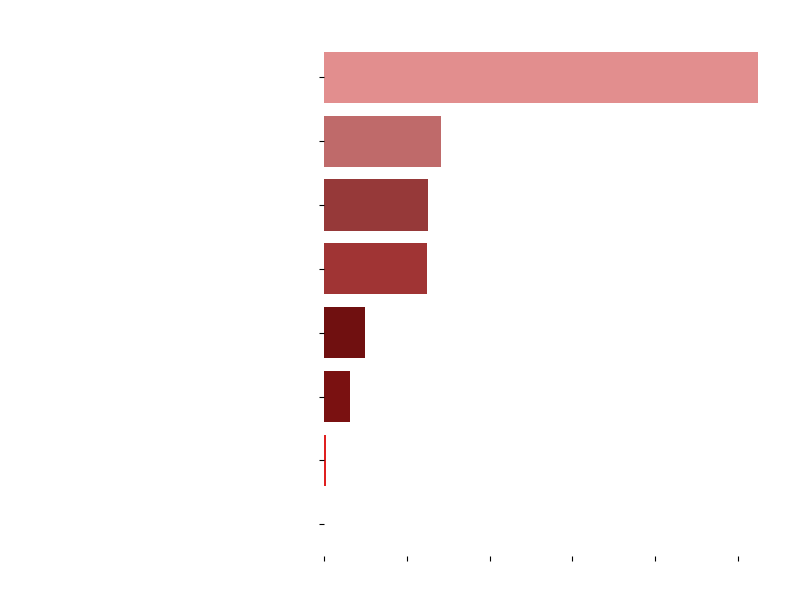

In [62]:
# Inspection type frequency visualized.
types = chicago['inspection_type'].value_counts(normalize = True)

plt.figure(figsize =  (8, 6))

sns.barplot(x = types.values,
            y = types.index,
            orient = 'h',
            palette = ['lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon'],
            hue = types.index,
            legend = False)

# Customization altered to match aesthetic of presentation and may not appear correctly in notebook if you have light theme.
plt.title('Inspection Type Ratios', color = 'white', fontsize = 25, fontweight = 'bold')
plt.ylabel('Inspection Type', color = 'white', fontsize = 22, fontweight = 'bold')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

ax = plt.gca()

# Set to transparent.
ax.patch.set_alpha(0)  
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/inspection_types.png');

**Three Most Common Inspection Types (referenced in data dictionary provided)**

- Canvass: the most common type of inspection performed at a frequency relative to the `risk` of the establishment.
- License: when the inspection is done as a requirement for the establishment to receive its license to operate.
- Complaint: when the inspection is done in response to a complaint against the establishment.

**Re-inspections can occur for most of the inspection types.**

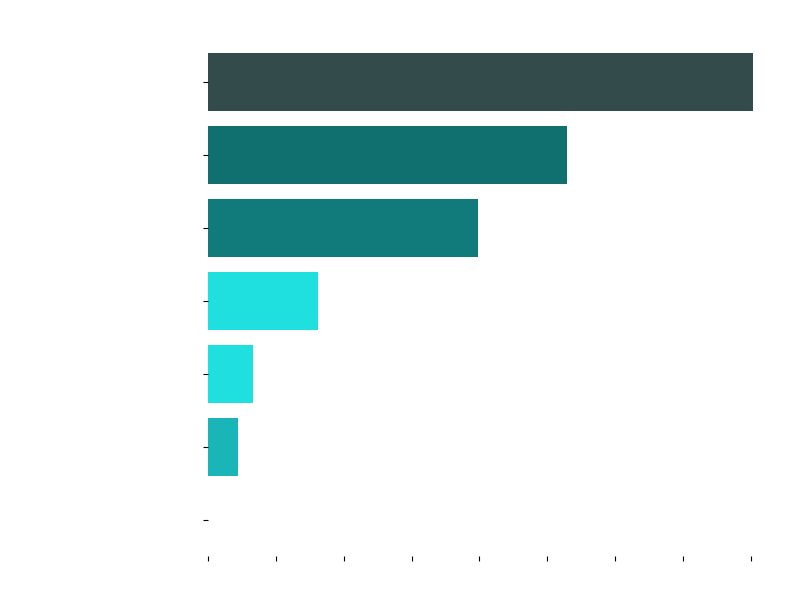

In [63]:
# Inspecton results visualized.
results = chicago['results'].value_counts(normalize = True)

plt.figure(figsize =  (8, 6))

sns.barplot(x = results.values,
            y = results.index,
            orient = 'h',
            palette = ['darkslategray', 'teal', 'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue'],
            hue = results.index,
            legend = False)

# Customization altered to match aesthetic of presentation and may not appear correctly in notebook if you have light theme.
plt.title('Ratio of Inspection Results', color = 'white', fontsize = 25, fontweight = 'bold')
plt.ylabel('Result', color = 'white', fontsize = 25, fontweight = 'bold')
plt.xlabel('')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

ax = plt.gca()

# Set to transparent.
ax.patch.set_alpha(0)  
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/inspection_results.png');

- More than 40% of inspections result in a **Pass**.
- Almost 1 in 5 inspections result in a **Fail**.

In [64]:
# For the purposes of a simpler problem to tackle initially and for binary classification in my modelling, I will simplify the results to just Pass or Fail.

# Referenced chicago.gov to make many judgement calls such as this one where I deem a 'Pass w/ Conditions' to have virtually the same merits as a straight Pass.
chicago['results'] = chicago['results'].replace('Pass w/ Conditions', 'Pass')

# Now I will drop results which are not Pass or Fail.
chicago = chicago[chicago['results'].isin(['Pass', 'Fail'])]
chicago.shape

(62556, 13)

- This method is risky as there is a possibility establishments who went out of business or deemed no entry could be re-opened later meaning they should not be removed from my dataset.
- A future workaround to this would be to search for the latest result by each establishment and check if they are still open as of latest inspection.
- I have not lost enough observations to deem this is a necessary task at the moment, but it should be solved eventually.

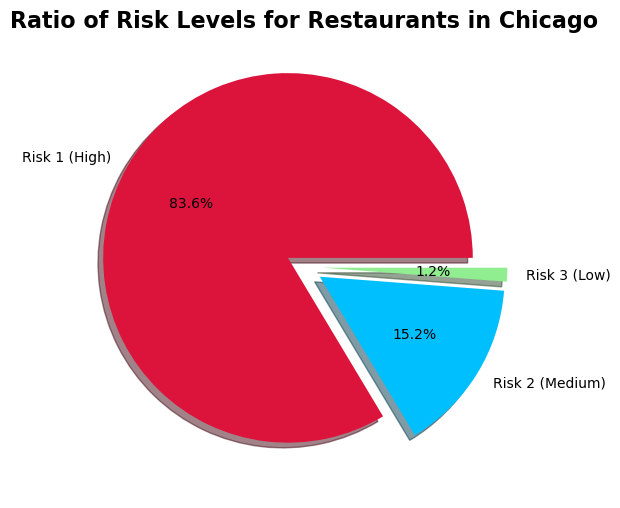

In [77]:
# Visualizing the 'risk' levels.
risks = chicago['risk'].value_counts()

plt.figure(figsize = (8, 6))

# The infamous Pie Chart, in honour of Hank Butler.
plt.pie(x = risks,
        labels = risks.index,
        autopct = '%1.1f%%',
        colors = ['crimson', 'deepskyblue', 'lightgreen'],
        explode = (0.1, 0.1, 0.1),
        shadow = True)

plt.title('Ratio of Risk Levels for Restaurants in Chicago', fontsize = 16, fontweight = 'bold')


# Save plot to images folder.
plt.savefig('../../images/risk_levels.png');

- Risk 1 (High) alarmed me at first being so frequent, But it makes intuitive sense since (according to the data dictionary) inspections are performed at a rate relative to the risk factor, so this data would be biased to have higher risk establishments since they are inspected more frequently.

- After [further research](https://www.chicago.gov/dam/city/depts/cdph/food_env/general/REGSSelfCertPilotdraftposting321.pdf) there is actually a lot to unpack in regards to the `Risk` of a an establishment, so I will explain a little further below.


The risk factor of an establishment is reflective of the potential hazards which could occur at the establishment and *not* necessarily a representation of dangerous practices. It is merely a classification method for identifying *if* such dangerous practices are possible. For example, a kiosk selling granola bars would be low risk as there is virtually zero chance for foodborne pathogens, cross-contamination, and any other food handling practices which could be improperly managed. On the other side of the spectrum (high risk) would be something like a Michelin Star restaurant, which handles many exotic ingredients from a wide range of suppliers and a multitude of cooking methods. While I have faith that those chefs are performing every task up to code, it is still technically true that there is **more** potential for something to go wrong. Just like with Big O notation that we must account for the worst case scenario, health departments must account for the worst case scenario and the risk factor is the representation of that.

---

### Violations

In [ ]:
# Observing how violation field is formatted so I can determine how I'd like to parse the values.
for violation in chicago[chicago['violations'] != 'No Violations']['violations'][:3]:
    print(violation)
    print('==' * 60)

22. PROPER COLD HOLDING TEMPERATURES - Comments: 3-501.16(A)(2) NOTED INTERNAL TEMPERATURES OF THE FOLLOWING TIME/TEMPERATURE CONTROL FOR SAFETY FOOD ITEMS INSIDE THE TWO-DOOR FOOD REFRIGERATOR TO BE IMPROPER: TRES LECHES 45. O F, HEAVY CREAM 48.6 F, RICE 73.0 F, SLICED MUSHROOMS 50.5 F, PEPPER SAUCE 55.6 F. MANAGER IMMEDIATELY AND VOLUNTARILY DISPOSED OF 20 LBS OF PRODUCTS WORTH $75.00 THROUGH DENATURING PROCESS. PRIORITY VIOLATION #7-38-005. CITATION ISSUED. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: 5-205.15(B) NOTED LEAKING FAUCET ABOVE SINK NEXT TO THE LAW TEMP DISH WASHER IN DISH WASHING AREA. INSTRUCTED TO REPAIR AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-201.17 OBSERVED THE CEILING TILES AND THE CEILING VENTILATION COVER WITH DIRT/DUST BUILD UP IN THE DISH WASH AREA AND ABOVE KITCHEN FOOD PREP AREA. INSTRUCTED TO CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.13: NOTED GRE

**Parsing Violation Notes**

- My first task is to extract only the violation code of this submission.

- There is an identifiable pattern in how the violations are written in which I can already see how I can pattern match to retreive the violation part alone: the violation code followed by a period and then the descriptor of the code, then a hyphen before Comments, then a separating bar (|) and the pattern is repeated for each violation.

*Note: For time reasons, in this project I will only be taking advantage of the violation codes, I can save it as a stretch goal for my app to evaluate the entirety of these entries (especially the `Comments` section) and display key words such as type of rodents found and type of contiminations.*

---
### Severity
- For the purposes of my app I would like to map these health codes to a severity level that is more 'real'.

- It will depend from place to place but I am using this capstone project to assess Chicago's health codes and give them more realistic severity values.

- For example, while Chicago does not state having rodents as a critical violation, customers might change their mind on eating somewhere after finding out there is/were infestations.
I am using my domain knowledge and years of experience discussing what customers look for in a restaurant when they go out to eat in terms of cleanliness and employee practices. This includes reading thousands and thousands of reviews and dealing with customers on a daily basis for more than 7 years. With this knowledge I can give a severity level to each health code of Chicago from 1 to 10.

In [68]:
def process_violations(violations):
    """
     This function will take the string of violations as input, parse it via splitting and regex, and perform calculations in order to obtain new features
     relating to the violations provided. If there are no violations, default values for each feature have been assigned.

     Input:
         violations - (string)
         
     Output:
         violation_count - (integer)
         violations_list_code - (list of integers)
         severity_levels - (list of int)
         average_severity - (float)
    """
    # Chicago health codes grouped by severity level.
    severity_map_reverse = {10: [3, 4, 5, 8, 9, 16, 17, 18, 19, 20, 28],
                            9: [21, 22, 59],
                            8: [1, 2, 11, 13, 15, 52, 53],
                            7: [7, 25, 23, 27, 33, 34, 35, 40, 42, 46, 60],
                            6: [10, 12, 14, 26, 29, 50, 57],
                            5: [51, 56, 43, 44, 45, 47],
                            4: [30, 31, 36, 38, 39, 41, 48, 49],
                            3: [37, 24, 32],
                            2: [6, 54, 63, 55],
                            1: [58, 61, 62]}

    if violations != 'No Violations':
        violations_list_str = violations.split(' | ')
        violation_count = len(violations_list_str)
        violations_list_code = [int(re.search(r'^\d{1,2}', v).group()) for v in violations_list_str]

        # Adding severity of each violation code found from above regex matching.
        severity_map = {code: severity for severity, violations_list_code in severity_map_reverse.items() for code in violations_list_code}
        severity_levels = [severity_map.get(code, 0) for code in violations_list_code]

        # Calculate average severity.
        average_severity = np.mean(severity_levels)
    else:
        violation_count = 0
        violations_list_code = []
        severity_levels = []
        average_severity = 0.0
        
    return violation_count, violations_list_code, severity_levels, average_severity

In [69]:
# Apply the function to the main dataframe to generate new columns.
chicago[['violation_count', 'violation_codes', 'severity_levels', 'average_severity']] = chicago['violations'].apply(
    lambda x: pd.Series(process_violations(x))
)

In [70]:
# Next feature, boolean value for whether the inspection is first or re-inspection.
chicago['is_reinspection'] = chicago['inspection_type'].str.contains('Re-Inspection')

In [71]:
# Double check that my created features have been added properly.
chicago.head()

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,average_severity,is_reinspection
10,2608132,S.K.Y.,S.K.Y.,2516847,Restaurant,Risk 1 (High),1239 W 18TH ST,2024-11-27,Standard Inspection,Pass,22. PROPER COLD HOLDING TEMPERATURES - Comment...,SKY,7,6,"[22, 51, 55, 55, 55, 56]","[9, 5, 2, 2, 2, 5]",4.166667,False
11,2608152,601 W COMPANIES,601 W COMPANIES,2988676,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2024-11-27,Required Inspection to Open,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",601 W COMPANIES,52,7,"[1, 5, 33, 36, 48, 50, 58]","[8, 10, 7, 4, 4, 6, 1]",5.714286,False
14,2608140,MC DONALD'S,MC DONALD'S,1045468,Restaurant,Risk 2 (Medium),6737 S PULASKI RD,2024-11-27,Standard Inspection,Pass,22. PROPER COLD HOLDING TEMPERATURES - Comment...,MC DONALDS,1,2,"[22, 55]","[9, 2]",5.500000,False
15,2608138,BEATNIK,BEATNIK,2609157,Restaurant,Risk 1 (High),1604-1608 W CHICAGO AVE,2024-11-27,Standard Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",BEATNIK,15,2,"[38, 50]","[4, 6]",5.000000,False
19,2608153,LOS 3 COMPADRES DE GUERRERO LLC,LOS 3 COMPADRES DE GUERRERO,2929721,Restaurant,Risk 1 (High),912 N WESTERN AVE,2024-11-27,Standard Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",LOS 3 COMPADRES DE GUERRERO,15,1,[55],[2],2.000000,True


---
## Final EDA of Engineered Features

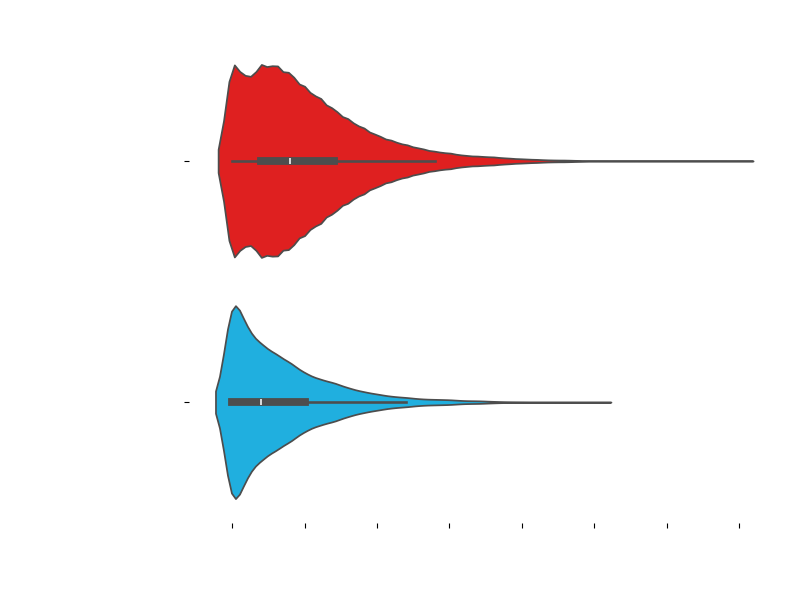

In [72]:
# Distribution of violation count depending on if it is reinspection.  
plt.figure(figsize = (8, 6))

sns.violinplot(
    data=chicago,
    x='violation_count',  
    y='is_reinspection', 
    palette = {True: 'deepskyblue', False: 'red'},
    hue = 'is_reinspection',
    orient='h',
    legend = False
)

# Customization altered to match aesthetic of presentation and may not appear correctly in notebook if you have light theme.
plt.title('Violation Count - First vs. Second Visit', fontsize = 20, color = 'white', fontweight = 'bold')
plt.xlabel('Violation Count', fontsize = 20, color = 'white', fontweight = 'bold')
ax = plt.gca()
ax.set_ylabel('')
ax.set_yticks([0, 1])
ax.set_yticklabels(['First Inspection', 'Re-Inspection'], fontsize = 16)

plt.xticks(color = 'white')
plt.yticks(color = 'white')

# Set to transparent.
ax.patch.set_alpha(0)  
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/violation_count_distributions.png');

- Restaurants tend to fix *most* of their mistakes before getting re-inspected, as I had hoped!

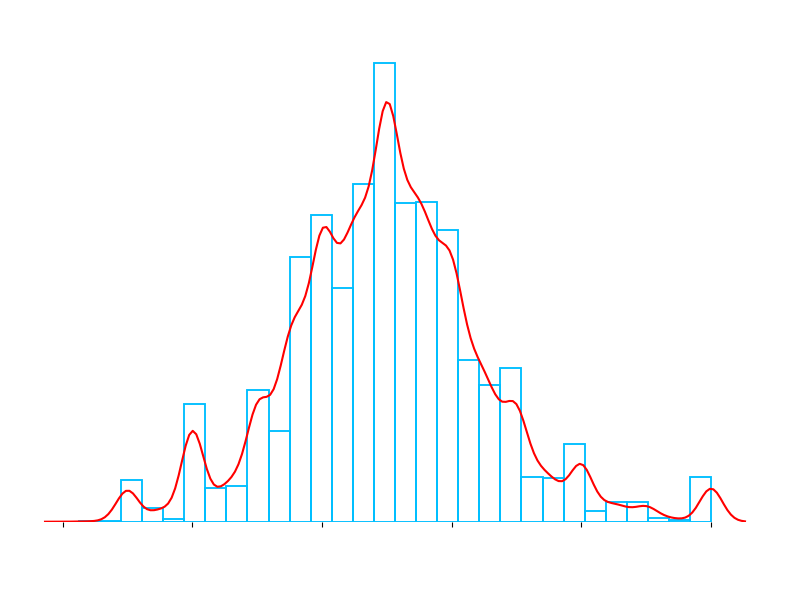

In [73]:
# Distribution of average severity.
severities = chicago[chicago['average_severity'] > 0]['average_severity']

plt.figure(figsize = (8, 6))

sns.histplot(severities,
             bins = 30,
             stat = 'density',
             fill = False,
             color = 'deepskyblue')
sns.kdeplot(severities, color = 'red')

# Customization altered to match aesthetic of presentation and may not appear correctly in notebook if you have light theme.
plt.title('Distribution of Average Severity Levels', fontsize = 22, color = 'white', fontweight = 'bold')
plt.xlabel('Severity Level', fontsize = 16, color = 'white', fontweight = 'bold')

ax = plt.gca()
ax.set_ylabel('')

plt.xticks(size = 14, color = 'white')
plt.yticks([], [])

# Set the plot to be transparent.
ax.patch.set_alpha(0) 
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/average_severity_distribution.png');

- These plots are mainly to double check that nothing wonky happened while creating these features, seeing a nice normal distribution centered around 5 is reassuring of that.

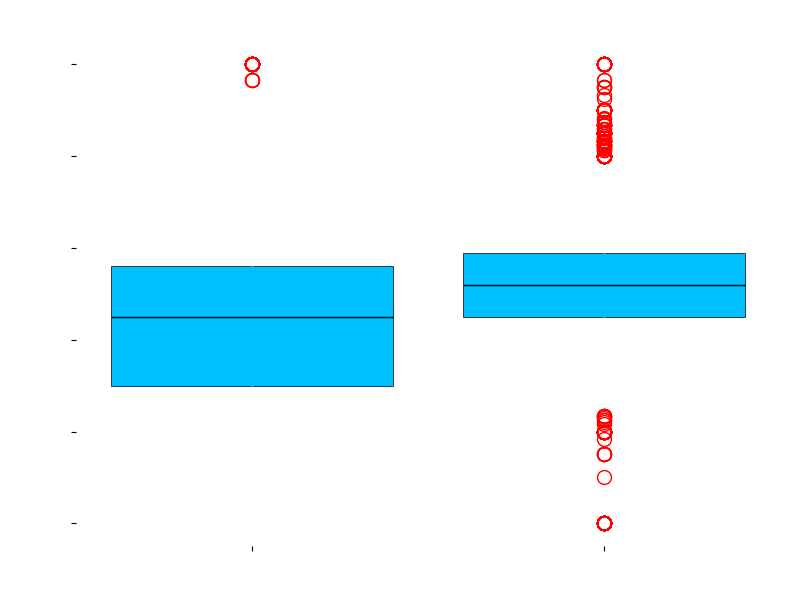

In [74]:
# Plotting average severity by Inpsection Result (Pass/Fail).
plt.figure(figsize = (8, 6))

sns.boxplot(data = chicago, x = 'results', y = 'average_severity',
            flierprops = {'marker': 'o', 'markeredgecolor': 'red', 'markersize': 10},
            boxprops = {'facecolor': 'deepskyblue', 'edgecolor': 'black', 'linewidth': 0.5},
            medianprops = {'color': 'black'},
            whiskerprops = {'color': 'white', 'linewidth': 1},
            capprops = {'color': 'white', 'linewidth': 1})

# Customization altered to match aesthetic of presentation and may not appear correctly in notebook if you have light theme.
plt.title('Average Severity by Inspection Result', color = 'white', fontsize = 22, fontweight = 'bold')
plt.ylabel('Severity Level', fontsize=22, color = 'white', fontweight = 'bold')

ax = plt.gca()
ax.set_xlabel('')

plt.xticks(color = 'white', fontsize = 18, fontweight = 'bold')
plt.yticks(color = 'white', fontsize = 12)

# Set the plot to be transparent.
ax.patch.set_alpha(0) 
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/average_severity_by_result.png');

- This test is more to see how useful this average severity feature could be used in my modelling for predicting pass or fail. The average severity of inspection failures are much more tightly packed around that 5-6 level. While the average severity of successful inspections is pretty much spread much looser across the whole range. On average the severity level in fails is slightly higher than passes, and the main takeaway here is that the majority of data points under `Fail` are clustered very close together in that 5-6 range, with the outliers tending to fall more above than below.

---
# Export Processed Data

In [75]:
chicago.to_csv('../../data/processed_chicago.csv', index = False)

# Continue To [Model](02_modelling.ipynb)